In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from functools import reduce


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, StackingRegressor

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('../data/epa_final.csv')

In [3]:
df.head()

,Date Local,Latitude,Longitude,PM2.5 Monthly Mean,lat_2dec,lon_2dec,no2,aod,temp,precip
0,2019-01-31,30.497478,-87.880258,6.825000,30.5,-87.88,1.541665e+15,0.052667,290.88,3.993249
1,2019-01-31,38.013333,-87.577222,9.860000,30.5,-87.88,1.120693e+15,0.035250,290.56,4.091899
2,2019-01-31,41.874999,-90.177574,10.290000,30.5,-87.88,1.374970e+15,0.201500,288.74,4.167067
3,2019-01-31,38.013333,-87.577222,7.222581,30.5,-87.88,1.120693e+15,0.035250,290.56,4.091899
4,2019-01-31,41.164400,-81.235200,8.762500,30.5,-87.88,1.421505e+15,0.035250,290.56,4.091899


In [4]:
df.shape

(13829, 10)

In [5]:
df = df[df['PM2.5 Monthly Mean'] > 0]

In [6]:
df.shape

(13828, 10)

In [7]:
X = df.drop(columns = ['Date Local','PM2.5 Monthly Mean', 'lat_2dec', 'lon_2dec'])
y = df['PM2.5 Monthly Mean']

In [8]:
X.head()

,Latitude,Longitude,no2,aod,temp,precip
0,30.497478,-87.880258,1.541665e+15,0.052667,290.88,3.993249
1,38.013333,-87.577222,1.120693e+15,0.035250,290.56,4.091899
2,41.874999,-90.177574,1.374970e+15,0.201500,288.74,4.167067
3,38.013333,-87.577222,1.120693e+15,0.035250,290.56,4.091899
4,41.164400,-81.235200,1.421505e+15,0.035250,290.56,4.091899


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [10]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [11]:
rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)
rf_train_pred = rf.predict(X_train_sc)
rf_test_pred = rf.predict(X_test_sc)
print(f'Random forest training score: {rf.score(X_train_sc,y_train)}')
print(f'Random forest test score: {rf.score(X_test_sc,y_test)}')

Random forest training score: 0.9348817680913113
Random forest test score: 0.6920198374102725


Unfortunately, no models we tried beat the random forest model, so we are making predictions with that!

In [12]:
level4_models = [
    ('bag', BaggingRegressor()),
    ('dt_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('rf', RandomForestRegressor())
    ])),
    ('lasso_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('lasso', LassoCV())
    ]))
]

stack3 = StackingRegressor(estimators=level4_models)

In [13]:
stack3.fit(X_train_sc,y_train)

StackingRegressor(estimators=[('bag', BaggingRegressor()),
                              ('dt_pipe',
                               Pipeline(steps=[('ss', StandardScaler()),
                                               ('rf',
                                                RandomForestRegressor())])),
                              ('lasso_pipe',
                               Pipeline(steps=[('ss', StandardScaler()),
                                               ('lasso', LassoCV())]))])

In [14]:
stack3.score(X_train_sc, y_train)

0.9319865308513013

In [15]:
stack3.score(X_test_sc, y_test)

0.6963161943082741

In [16]:
jantest = pd.read_csv('../data/monthly_test_data/result_1k/1_2019.csv')
jantest = jantest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
jantest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
jantest.dropna(inplace = True)
jan_x = ss.transform(jantest)
jan_preds = rf.predict(jan_x)
jantest['PM25'] = jan_preds

In [17]:
jantest.head()

,Latitude,Longitude,no2,aod,temp,precip,PM25
0,41.74735,-72.31644,2.310810e+15,0.017500,272.86000,6.950767,7.875484
1,39.95843,-102.90854,1.476430e+15,0.017333,282.62000,0.273165,9.362179
2,37.78384,-80.16877,1.335590e+15,0.030000,275.10000,3.002049,6.917518
3,32.59222,-100.61852,1.339840e+15,-0.003071,290.41998,0.471000,7.146468
4,35.34759,-120.25252,1.158480e+15,0.009571,287.46000,4.177359,6.267224


<AxesSubplot:>

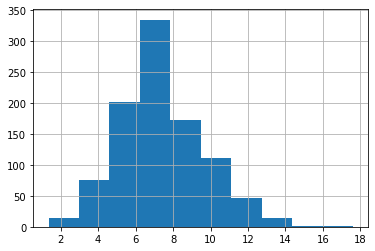

In [18]:
jantest['PM25'].hist()

<AxesSubplot:>

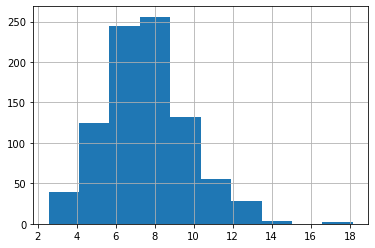

In [19]:
febtest = pd.read_csv('../data/monthly_test_data/result_1k/2_2019.csv')
febtest = febtest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
febtest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
febtest.dropna(inplace = True)
feb_x = ss.transform(febtest)
feb_preds = rf.predict(feb_x)
febtest['PM25'] = feb_preds
febtest['PM25'].hist()

<AxesSubplot:>

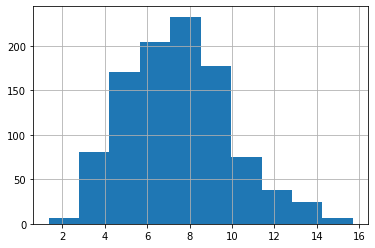

In [20]:
martest = pd.read_csv('../data/monthly_test_data/result_1k/3_2019.csv')
martest = martest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
martest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
martest.dropna(inplace = True)
mar_x = ss.transform(martest)
mar_preds = rf.predict(mar_x)
martest['PM25'] = mar_preds
martest['PM25'].hist()

<AxesSubplot:>

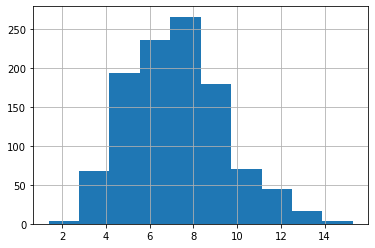

In [21]:
aprtest = pd.read_csv('../data/monthly_test_data/result_1k/4_2019.csv')
aprtest = aprtest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
aprtest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
aprtest.dropna(inplace = True)
apr_x = ss.transform(aprtest)
apr_preds = rf.predict(apr_x)
aprtest['PM25'] = apr_preds
aprtest['PM25'].hist()

<AxesSubplot:>

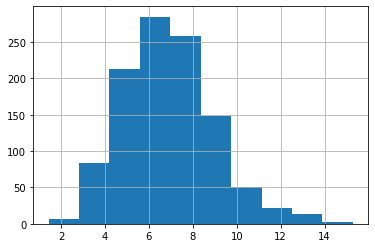

In [22]:
maytest = pd.read_csv('../data/monthly_test_data/result_1k/5_2019.csv')
maytest = maytest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
maytest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
maytest.dropna(inplace = True)
may_x = ss.transform(maytest)
may_preds = rf.predict(may_x)
maytest['PM25'] = may_preds
maytest['PM25'].hist()

<AxesSubplot:>

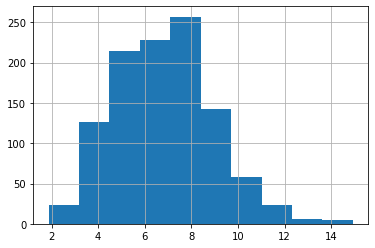

In [23]:
juntest = pd.read_csv('../data/monthly_test_data/result_1k/6_2019.csv')
juntest = juntest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
juntest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
juntest.dropna(inplace = True)
jun_x = ss.transform(juntest)
jun_preds = rf.predict(jun_x)
juntest['PM25'] = jun_preds
juntest['PM25'].hist()

<AxesSubplot:>

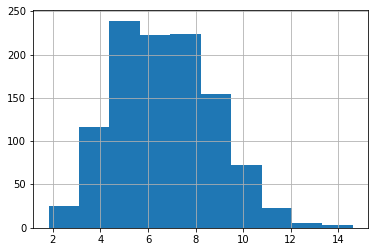

In [24]:
jultest = pd.read_csv('../data/monthly_test_data/result_1k/7_2019.csv')
jultest = jultest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
jultest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
jultest.dropna(inplace = True)
jul_x = ss.transform(jultest)
jul_preds = rf.predict(jul_x)
jultest['PM25'] = jul_preds
jultest['PM25'].hist()

<AxesSubplot:>

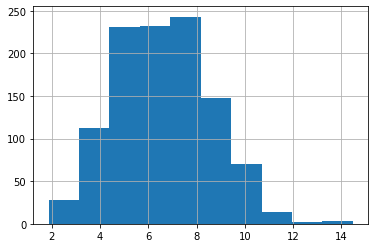

In [25]:
augtest = pd.read_csv('../data/monthly_test_data/result_1k/8_2019.csv')
augtest = augtest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
augtest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
augtest.dropna(inplace = True)
aug_x = ss.transform(augtest)
aug_preds = rf.predict(aug_x)
augtest['PM25'] = aug_preds
augtest['PM25'].hist()

<AxesSubplot:>

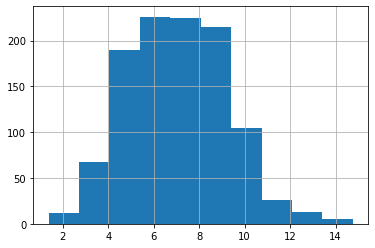

In [26]:
septest = pd.read_csv('../data/monthly_test_data/result_1k/9_2019.csv')
septest = septest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
septest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
septest.dropna(inplace = True)
sep_x = ss.transform(septest)
sep_preds = rf.predict(sep_x)
septest['PM25'] = sep_preds
septest['PM25'].hist()

<AxesSubplot:>

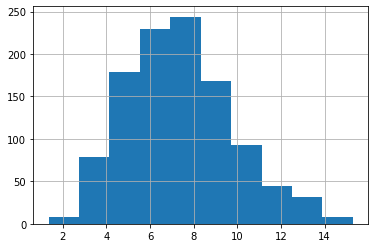

In [27]:
octtest = pd.read_csv('../data/monthly_test_data/result_1k/10_2019.csv')
octtest = octtest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
octtest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
octtest.dropna(inplace = True)
oct_x = ss.transform(octtest)
oct_preds = rf.predict(oct_x)
octtest['PM25'] = oct_preds
octtest['PM25'].hist()

<AxesSubplot:>

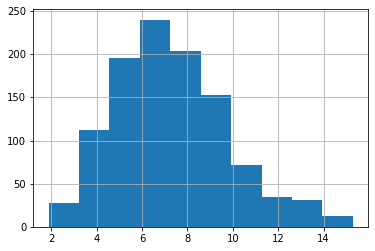

In [28]:
novtest = pd.read_csv('../data/monthly_test_data/result_1k/11_2019.csv')
novtest = novtest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
novtest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
novtest.dropna(inplace = True)
nov_x = ss.transform(novtest)
nov_preds = rf.predict(nov_x)
novtest['PM25'] = nov_preds
novtest['PM25'].hist()

<AxesSubplot:>

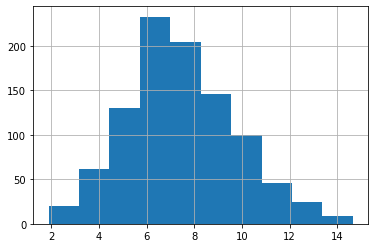

In [29]:
dectest = pd.read_csv('../data/monthly_test_data/result_1k/12_2019.csv')
dectest = dectest.reindex(columns=['lat','lon', 'NO2_2019','AOD_2019','temp_2019','precip_2019'])
dectest.rename(columns={"lat": "Latitude", "lon": "Longitude", 'NO2_2019':'no2', 'AOD_2019':'aod','temp_2019':'temp','precip_2019':'precip'}, inplace = True)
dectest.dropna(inplace = True)
dec_x = ss.transform(dectest)
dec_preds = rf.predict(dec_x)
dectest['PM25'] = dec_preds
dectest['PM25'].hist()

In [30]:
jantest = jantest[['Latitude', 'Longitude', 'PM25']]
febtest = febtest[['Latitude', 'Longitude', 'PM25']]
martest = martest[['Latitude', 'Longitude', 'PM25']]
aprtest = aprtest[['Latitude', 'Longitude', 'PM25']]
maytest = maytest[['Latitude', 'Longitude', 'PM25']]
juntest = juntest[['Latitude', 'Longitude', 'PM25']]
jultest = jultest[['Latitude', 'Longitude', 'PM25']]
augtest = augtest[['Latitude', 'Longitude', 'PM25']]
septest = septest[['Latitude', 'Longitude', 'PM25']]
octtest = octtest[['Latitude', 'Longitude', 'PM25']]
novtest = novtest[['Latitude', 'Longitude', 'PM25']]
dectest = dectest[['Latitude', 'Longitude', 'PM25']]

In [31]:
df_list = [jantest, febtest, martest, aprtest, maytest, juntest, jultest, augtest,
           septest, octtest, novtest, dectest]

In [32]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Latitude', 'Longitude'], how='left'), df_list)

In [33]:
final_df.head()

,Latitude,Longitude,PM25_x,PM25_y,PM25_x,PM25_y,PM25_x,PM25_y,PM25_x,PM25_y,PM25_x,PM25_y,PM25_x,PM25_y
0,41.74735,-72.31644,7.875484,6.776958,6.426692,5.838279,6.834080,5.584230,5.835429,5.369793,6.595135,7.893117,7.625866,6.461129
1,39.95843,-102.90854,9.362179,9.283008,9.778341,7.060599,7.731196,8.095561,8.095561,7.910631,7.151650,7.003416,9.592648,9.253324
2,37.78384,-80.16877,6.917518,7.249476,6.939534,6.713797,6.415669,7.688192,6.818815,7.055255,7.271621,7.244967,6.851304,6.706850
3,32.59222,-100.61852,7.146468,7.856849,7.750433,9.426934,9.680642,9.597088,9.768031,9.768031,9.207964,9.857884,7.419365,7.039243
4,35.34759,-120.25252,6.267224,6.636152,3.276971,4.235493,5.767051,6.101290,5.903553,6.012493,5.995092,5.580177,4.300518,6.249472


In [34]:
final_df.columns = ['lat', 'lon', 'PM25_1', 'PM25_2', 'PM25_3', 'PM25_4', 'PM25_5', 'PM25_6', 
                   'PM25_7', 'PM25_8', 'PM25_9', 'PM25_10_', 'PM25_11', 'PM25_12']

In [35]:
final_df.head()

,lat,lon,PM25_1,PM25_2,PM25_3,PM25_4,PM25_5,PM25_6,PM25_7,PM25_8,PM25_9,PM25_10_,PM25_11,PM25_12
0,41.74735,-72.31644,7.875484,6.776958,6.426692,5.838279,6.834080,5.584230,5.835429,5.369793,6.595135,7.893117,7.625866,6.461129
1,39.95843,-102.90854,9.362179,9.283008,9.778341,7.060599,7.731196,8.095561,8.095561,7.910631,7.151650,7.003416,9.592648,9.253324
2,37.78384,-80.16877,6.917518,7.249476,6.939534,6.713797,6.415669,7.688192,6.818815,7.055255,7.271621,7.244967,6.851304,6.706850
3,32.59222,-100.61852,7.146468,7.856849,7.750433,9.426934,9.680642,9.597088,9.768031,9.768031,9.207964,9.857884,7.419365,7.039243
4,35.34759,-120.25252,6.267224,6.636152,3.276971,4.235493,5.767051,6.101290,5.903553,6.012493,5.995092,5.580177,4.300518,6.249472


In [36]:
final_df.dropna(inplace = True)

In [38]:
final_df.to_csv('../data/monthly_test_data/final_PM25.csv', index = False)